# Background Removal

In [2]:
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image
import os
import torch
import pandas as pd
from matplotlib import rcParams
rcParams['figure.figsize'] = (17,7)
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import recall_score, precision_score, fbeta_score

from src.u2net import U2NET, normPRED
from src.utils import get_result, cascade, save_mask_model
from src.scores import iou_pytorch, score_model, score_all_metric
from src.painting import Painting

## 1. Загрузка модели U2Net

Для задачи обнаружения заметных объектов возьмем предобученную модель U2Net, описанную в статье [Salient Object Detection](https://arxiv.org/pdf/2005.09007.pdf), из репозитория [U-2-Net](https://github.com/xuebinqin/U-2-Net)

In [3]:
device = torch.device('cpu' if torch.cuda.is_available() else 'cpu')
model = U2NET().to(device)
model.load_state_dict(torch.load('u2net.pth'))
model = model.eval()

### Метрики

Для оценки качества будем использовать 4 метрики: Fbeta, Iou, Precision, Recall. 

$$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{\text { prediction } }}$$

Пересечение ($\text {target } \cap \text { prediction }$) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение ($\text {target } \cup \text { prediction }$) просто состоит из всех пикселей, найденных в маске предсказания или в целевой маске.

$$precision = \frac{TP}{TP + FP}\qquad\qquad  recall = \frac{TP}{TP + FN}$$

TP - количество пикселей, где модель правильно предсказала объект;
TN - количество пикселей, где модель правильно предсказала фон;
FP - количество пикселей, где модель неправильно предсказала объект;
FN - количество пикселей, где модель неправильно предсказала фон.

$$\ F_\beta =  \frac{(1 + \beta^2) \cdot precision \cdot recall}{\beta^2 \cdot precision + recall},$$
где $\beta\in (0,1]$. Далее мы выбрали $\beta=0.3$, как выбрано в статье.

## 2. DUTS dataset

Будет работать с [DUTS dataset](http://saliencydetection.net/duts/), на котором обучалась модель U2Net. Изображения нужно преобразовать в тензоры, изменить размер и нормализовать.

In [4]:
images = []
mask = []
images_init = []
images_test = []
images_test_init = []
mask_test = []

root = 'DUTS-TR/DUTS-TR-Image'
root_test = 'DUTS-TE/DUTS-TE-Image'

transform_im = transforms.Compose([
            transforms.Resize((128, 128)),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
        ])
transform_ms = transforms.Compose([
            transforms.Resize((128, 128)),
            transforms.ToTensor(),
        ])

# Будем работать с 1000 картинками
number_im = 1000
for name in os.listdir(root)[:number_im]:
    images_init.append(transform_ms(Image.open(os.path.join(root, name))))
    images.append(transform_im(Image.open(os.path.join(root, name))))
    mask.append(transform_ms(Image.open(os.path.join('DUTS-TR/DUTS-TR-Mask', name[:-4]+'.png'))))
    
for name in os.listdir(root_test)[:number_im]:
    images_test_init.append(transform_ms(Image.open(os.path.join(root_test, name))))
    images_test.append(transform_im(Image.open(os.path.join(root_test, name))))
    b = transform_ms(Image.open(os.path.join('DUTS-TE/DUTS-TE-Mask', name[:-4]+'.png')))
    if len(b) != 1:
        b = b[0].reshape(1, 128, 128)
    mask_test.append(b)
    
data_load = DataLoader(list(zip(images, mask)), 25)
data_load_test = DataLoader(list(zip(images_test, mask_test)), 25)

### 2.1. Топ лучших и худших score для DUTS-TE

Выведем 5 картинок с лучшими и худшими score по метрике Iou

In [5]:
data_load_test_1 = DataLoader(list(zip(images_test, mask_test)))

argsort_scores = score_model(model, iou_pytorch, data_load_test_1, device=device)

In [6]:
top = 5

Первой строчкой выводятся реальные изображения, второй их маски и третьей строчкой маски, предсказанные моделью

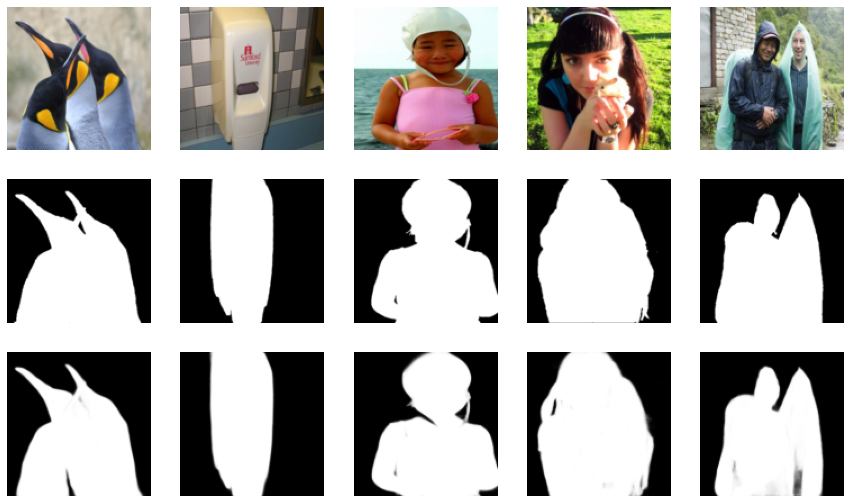

In [7]:
mask_model = [images_test[i] for i in argsort_scores[-top:]]
mask_t = [mask_test[i] for i in argsort_scores[-top:]]
images_t = [images_test_init[i] for i in argsort_scores[-top:]]
Painting([images_t, mask_t, save_mask_model(model, mask_model)], figsize=(15,9))

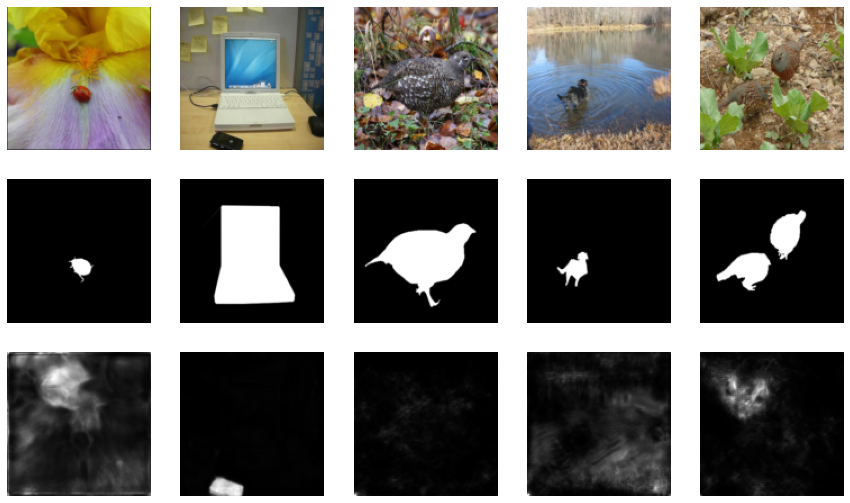

In [8]:
mask_model = [images_test[i] for i in argsort_scores[:top]]
mask_t = [mask_test[i] for i in argsort_scores[:top]]
images_t = [images_test_init[i] for i in argsort_scores[:top]]
Painting([images_t, mask_t, save_mask_model(model, mask_model)], figsize=(15,9))

Модель U2Net не может определить на некоторых изображениях центральный объект

# 3. Модель CascadePSP

Попробуем улучшить полученные маски моделью [CascadePSP](https://github.com/hkchengrex/CascadePSP)

In [12]:
N = 1000
mask_u2net, result = get_result(model, images_test, images_test_init, N)

Отрисовка первых 10 картинок в порядке: изображения, настоящие маски, макси из U2Net, макси из U2Net+CascadePSP.

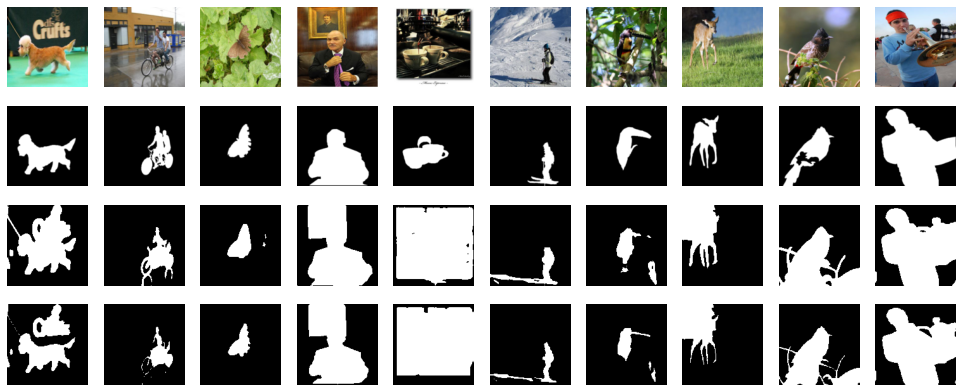

In [38]:
Painting([images_test_init, mask_test, mask_u2net, result], 10, figsize=(17,7))

Модель CascadePSP хорошо восстанавливет и уточняет маски, полученные моделью U2Net. Однако CascadePSP не способен координально изменить маску.

Посмотрим на изменение качества для первых 10 картинок по метрике Iou.

In [33]:
score_iou_1 = [iou_pytorch(mask_u2net[i]>=0.2, mask_test[i], False).item() for i in range(10)]
score_iou_2 = [iou_pytorch(result[i], mask_test[i], False).item() for i in range(10)]

In [34]:
pd.DataFrame([score_iou_1, score_iou_2], index=["U2Net", "U2Net+Cascade"])

,0,1,2,3,4,5,6,7,8,9
U2Net,0.389467,0.463722,0.652767,0.587345,0.130633,0.426983,0.528169,0.296911,0.308386,0.812133
U2Net+Cascade,0.521387,0.454123,0.854123,0.638418,0.139325,0.641935,0.659706,0.340752,0.371858,0.854479


## 3.1 Качество на DUT-TR

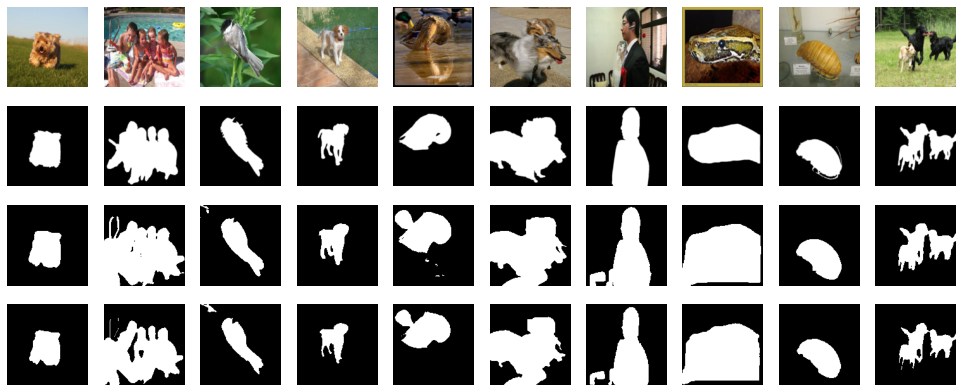

In [16]:
mask_u2net_tr, result_tr = get_result(model, images, images_init, N)
Painting([images_init, mask, mask_u2net_tr, result_tr], 10, figsize=(17,7))

Получим качество для DUTS-TR по 4 метрикам: Fbeta (0.3), Iou, Precision, Recall.

In [17]:
a = []
a.append(score_all_metric([fbeta_score, iou_pytorch, precision_score, recall_score], mask_u2net_tr, mask))
a.append(score_all_metric([fbeta_score, iou_pytorch, precision_score, recall_score], result_tr, mask))
b = ['U2Net', 'U2Net+Cascade']
pd.DataFrame(a, columns = ['F beta (0.3)', 'Iou', 'Precision', 'Recall'], index = b)

,F beta (0.3),Iou,Precision,Recall
U2Net,0.769651,0.747209,0.756942,0.981129
U2Net+Cascade,0.877359,0.845272,0.873047,0.962645


Качество модели U2Net конечно же достаточно хорошее на тренировочном датасете

# 4. Устойчивость к шуму

Попробуем добавить немного шума к исходным изображениям

In [18]:
torch.manual_seed(0)

transform_no = transforms.Compose([
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
transform_im = transforms.Compose([
            transforms.Resize((128, 128)),
            transforms.ToTensor()])

number_im = 1000
images_test_no = []
images_test_no_init = []

for name in os.listdir(root_test)[:number_im]:
    t = torch.randn(3, 128, 128)*0.1
    images_test_no_init.append(torch.clamp(transform_im(Image.open(os.path.join(root_test, name)))+t, 0, 1))
    images_test_no.append(transform_no(torch.clamp(transform_im(Image.open(os.path.join(root_test, name)))+t, 0, 1)))
    
data_noise_test = DataLoader(list(zip(images_test_no, mask_test)), 25, num_workers=2)

In [19]:
mask_u2net_no, result_no = get_result(model, images_test_no, images_test_no_init, N)

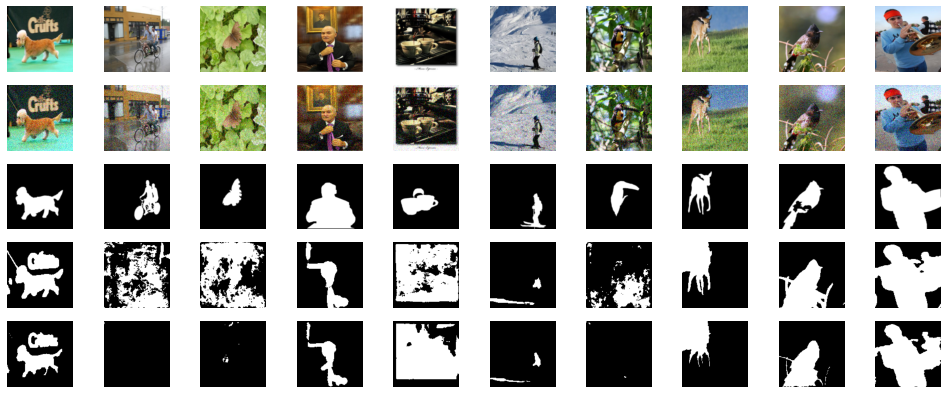

In [20]:
Painting([images_test_init, images_test_no_init, mask_test, mask_u2net_no, result_no], 10, figsize=(17,7))

Маски модели U2Net стали заметно хуже после добавления шума. Модель CascadePSP не может преобразовать в лучшую сторону сильно испорченные маски. Такое наблюдается на 2, 3, 5 и 7 изображениях

In [35]:
score_iou_1 = [iou_pytorch(mask_u2net_no[i]>=0.2, mask_test[i], False).item() for i in range(10)]
score_iou_2 = [iou_pytorch(result_no[i], mask_test[i], False).item() for i in range(10)]

In [36]:
pd.DataFrame([score_iou_1, score_iou_2], index=["U2Net", "U2Net+Cascade"])

,0,1,2,3,4,5,6,7,8,9
U2Net,0.458169,1.188243e-01,0.070183,0.330723,0.119228,0.203051,4.338300e-02,0.288442,0.343176,0.776576
U2Net+Cascade,0.579181,7.587254e-12,0.058005,0.328735,0.166559,0.259001,8.764242e-12,0.333633,0.431276,0.842208


In [23]:
quality = []
for mask in [mask_u2net, mask_u2net_no, result, result_no]:
    quality.append(score_all_metric([fbeta_score, iou_pytorch, precision_score, recall_score], mask, mask_test))
index = ['U2Net', 'U2Net with noise', 'U2Net+Cascade', 'U2Net+Cascade with noise']

In [24]:
pd.DataFrame(quality, columns=['F beta (0.3)', 'Iou', 'Precision', 'Recall'], index=index)

,F beta (0.3),Iou,Precision,Recall
U2Net,0.509518,0.475166,0.497363,0.876859
U2Net with noise,0.455016,0.391431,0.453128,0.685623
U2Net+Cascade,0.635154,0.581128,0.632222,0.843523
U2Net+Cascade with noise,0.515172,0.413197,0.552206,0.540123


Как видно из таблицы и изображений, качество падает после добавления шума. Модель U2Net не устойчива к шуму

## 5. Other datasets

Посмотрим на предсказания моделей для [ECSSD dataset](http://www.cse.cuhk.edu.hk/~leojia/projects/hsaliency/dataset.html) и [OMRON dataset](http://saliencydetection.net/dut-omron/#org96c3bab)

In [26]:
images_OMRON = []
images_OMRON_until = []
mask_OMRON = []
images_ECSSD = []
images_ECSSD_until = []
mask_ECSSD = []

root_OMRON = 'DUT-OMRON-image/DUT-OMRON-image/'
root_ECSSD = 'images/'

transform_im = transforms.Compose([
            transforms.Resize((128, 128)),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
        ])
transform_ms = transforms.Compose([
            transforms.Resize((128, 128)),
            transforms.ToTensor(),
        ])

number_im = 500
for name in os.listdir(root_OMRON)[:number_im]:
    images_OMRON_until.append(transform_ms(Image.open(os.path.join(root_OMRON, name))))
    images_OMRON.append(transform_im(Image.open(os.path.join(root_OMRON, name))))
    b = transform_ms(Image.open(os.path.join('pixelwiseGT-new-PNG/', name[:-4]+'.png')))
    if len(b) != 1:
        b = b[0].reshape(1, 128, 128)
    mask_OMRON.append(b)
    
for name in os.listdir(root_ECSSD)[:number_im]:
    images_ECSSD_until.append(transform_ms(Image.open(os.path.join(root_ECSSD, name))))
    images_ECSSD.append(transform_im(Image.open(os.path.join(root_ECSSD, name))))
    b = transform_ms(Image.open(os.path.join('ground_truth_mask/', name[:-4]+'.png')))
    if len(b) != 1:
        b = b[0].reshape(1, 128, 128)
    mask_ECSSD.append(b)

### 5.1. DUT-Omron

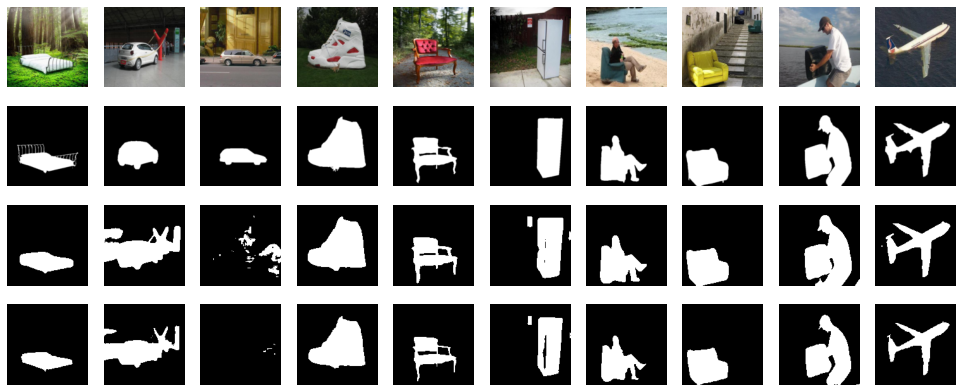

In [27]:
N = 500
u2net_OMRON, result_OMRON = get_result(model, images_OMRON, images_OMRON_until, N)
Painting([images_OMRON_until, mask_OMRON, u2net_OMRON, result_OMRON], 10, figsize=(17,7))

In [28]:
a = []
a.append(score_all_metric([fbeta_score, iou_pytorch, precision_score, recall_score], u2net_OMRON, mask_OMRON))
a.append(score_all_metric([fbeta_score, iou_pytorch, precision_score, recall_score], result_OMRON, mask_OMRON))
b = ['U2Net', 'U2Net+Cascade']
pd.DataFrame(a, columns = ['F beta (0.3)', 'Iou', 'Precision', 'Recall'], index = b)

,F beta (0.3),Iou,Precision,Recall
U2Net,0.517441,0.468771,0.512120,0.778754
U2Net+Cascade,0.614573,0.540051,0.625766,0.727884


Несмотря на то, что качество не высокое, некоторые маски получились крайне похожими на реальные маски. Проблема с обработкой изображений, в которых центральный объект сливается по цвету с фоном или объект расположен далеко 

### 5.2. ECSSD

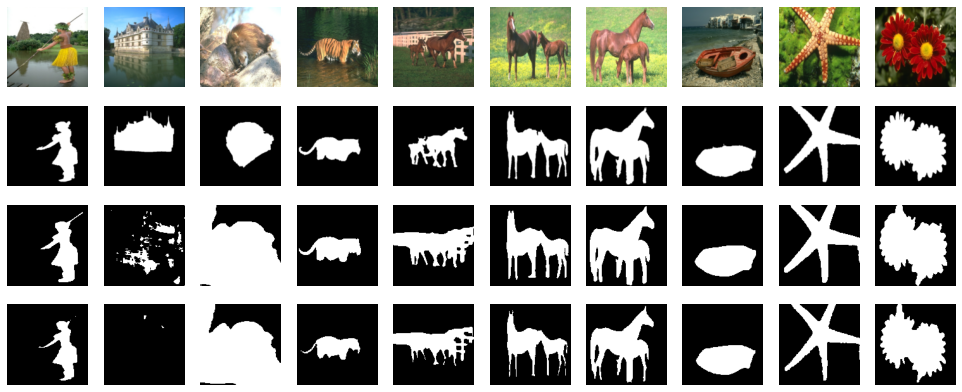

In [29]:
u2net_ECSSD, result_ECSSD = get_result(model, images_ECSSD, images_ECSSD_until, N)
Painting([images_ECSSD_until, mask_ECSSD, u2net_ECSSD, result_ECSSD], 10, figsize=(17,7))

In [30]:
a = []
a.append(score_all_metric([fbeta_score, iou_pytorch, precision_score, recall_score], u2net_ECSSD, mask_ECSSD))
a.append(score_all_metric([fbeta_score, iou_pytorch, precision_score, recall_score], result_ECSSD, mask_ECSSD))
b = ['U2Net', 'U2Net+Cascade']
pd.DataFrame(a, columns = ['F beta (0.3)', 'Iou', 'Precision', 'Recall'], index = b)

,F beta (0.3),Iou,Precision,Recall
U2Net,0.730391,0.695248,0.720454,0.933291
U2Net+Cascade,0.834047,0.782716,0.836472,0.904675


В данном датасете преобладают картинки с хорошо выделенными центральными объектами, поэтому качество получилось хорошим

В целом, сочетание моделей U2Net и CascadePSP дает очень хорошее качество на изображениях с центральным объектом. Есть проблемы с распознованием объектов, которые сливаются с фоном, и с картинками, где центральный объект расположен далеко и занимает малую площадь от всей фотографии. Также наблюдается распространенная проблема для глубоких сетей - неустойчивость к шумам. Данную проблему, возможно, можно решить дообучением на зашумленных изображенях, или какими-либо другими методами для таких проблем.